In [4]:
# Running the Colab Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing of the necessary libraries and the modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,cross_validate,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,log_loss,roc_curve
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,average_precision_score,brier_score_loss
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns',500)
pd.set_option('Display.max_rows',500)
gc.collect()

4

#Reducing the memory usage

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

First we will load the merged dataframe. And then  we need to call reduce_mem_usage function in order to use the memory efficiently and fasten the processes.

#Loading data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Home Credit/home-credit-default-risk/mergetrain2.csv')
app_train = reduce_mem_usage(df)

Memory usage of dataframe is 2285.12 MB
Memory usage after optimization is: 679.50 MB
Decreased by 70.3%


In [6]:
gc.collect()


55

##Train Test Split

In [7]:
train_df, test_df = train_test_split(app_train,test_size=0.20,shuffle=True,stratify=app_train.TARGET,
                                     random_state=217)

In [9]:
x_calls = train_df.columns[2:]

##Model LightGBM

First we will use basic metrics for the merged dataframe. According to the results, we will change the metrics.

In [10]:
model_gbm = LGBMClassifier(application= 'binary',
    objective= 'binary',
    metric= 'auc',
    is_unbalance= 'true',
    boosting= 'gbdt',
    feature_fraction= 0.5,
    bagging_fraction= 0.5,
    bagging_freq= 20,
    num_leaves= 32,
    learning_rate= 0.005,
    verbose= -1,
    silent=-1,
    min_child_weight=40,
    min_split_gain=0.0222415,
    reg_lambda=0.073,
    reg_alpha=0.04,
    max_depth=8,
    subsample=0.8715623,
    colsample_bytree=0.9497036,
    n_estimators=10000,
    nthread=4)
model_gbm.fit(train_df[x_calls], train_df.TARGET)

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
               boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9497036, feature_fraction=0.5,
               importance_type='split', is_unbalance='true',
               learning_rate=0.005, max_depth=8, metric='auc',
               min_child_samples=20, min_child_weight=40,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=-1,
               nthread=4, num_leaves=32, objective='binary', random_state=None,
               reg_alpha=0.04, reg_lambda=0.073, silent=-1, subsample=0.8715623,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [11]:
gc.collect()

predictions = model_gbm.predict(test_df[x_calls])
prob = model_gbm.predict_proba(test_df[x_calls])[:,1]
test_df['TARGET_hat']=predictions
test_df['TARGET_prob']=prob
Y_validation = test_df.TARGET
print("Accuracy Score: %f" % accuracy_score(Y_validation, predictions))
print("ROC_AUC: %f" % roc_auc_score(Y_validation, prob,average='weighted'))
print("PR_AUC: %f" % average_precision_score(Y_validation, prob,average='weighted'))
print("F1: %f" % f1_score(Y_validation, predictions,average='weighted'))
print("Recall: %f" % recall_score(Y_validation, predictions,average='weighted'))
print("Precision: %f" % precision_score(Y_validation, predictions,average='weighted'))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy Score: 0.792595
ROC_AUC: 0.796653
PR_AUC: 0.298783
F1: 0.832906
Recall: 0.792595
Precision: 0.900654
[[45667 10871]
 [ 1885  3080]]
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     56538
         1.0       0.22      0.62      0.33      4965

    accuracy                           0.79     61503
   macro avg       0.59      0.71      0.60     61503
weighted avg       0.90      0.79      0.83     61503



We will show the results in curve.

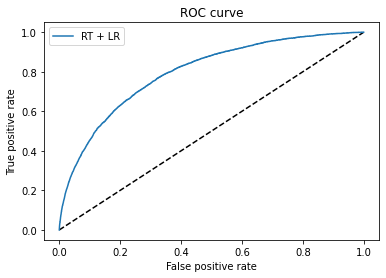

In [12]:
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(test_df.TARGET, test_df.TARGET_prob)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

First results seems very good. But we have some additional options to increase the score. Therefore, we will go into details the feature importances by using LightGBM`s 'feature_importances_' attribute.

In [13]:
importances = model_gbm.feature_importances_
indices = np.argsort(importances)[::-1]

In [14]:
def variable_importance(importance, indices,x):
    print("Feature ranking:")
    importances = []
    for f in range(len(x)):
        i = f
        t=0
        print("%d. The feature '%s' has a Mean Decrease in Gini of %f" % (f + 1,x[indices[i]],importance[indices[f]]))
        importances.append([x[indices[i]],importance[indices[f]]])
    importances = pd.DataFrame(importances,columns=['Features','Gini'])
    return importances

importance = variable_importance(importances, indices,x_calls)
importance.info()

Feature ranking:
1. The feature 'EXT_SOURCE_2' has a Mean Decrease in Gini of 3975.000000
2. The feature 'CREDIT_TERM' has a Mean Decrease in Gini of 3884.000000
3. The feature 'EXT_SOURCE_3' has a Mean Decrease in Gini of 3699.000000
4. The feature 'EXT_SOURCE_1' has a Mean Decrease in Gini of 2760.000000
5. The feature 'AMT_ANNUITY' has a Mean Decrease in Gini of 2486.000000
6. The feature 'DAYS_BIRTH' has a Mean Decrease in Gini of 2334.000000
7. The feature 'b_DAYS_CREDIT_max' has a Mean Decrease in Gini of 2190.000000
8. The feature 'client_installments_AMT_PAYMENT_min_sum' has a Mean Decrease in Gini of 2170.000000
9. The feature 'DAYS_ID_PUBLISH' has a Mean Decrease in Gini of 2157.000000
10. The feature 'YEARS_BIRTH' has a Mean Decrease in Gini of 2150.000000
11. The feature 'ANNUITY_TO_INCOME' has a Mean Decrease in Gini of 2032.000000
12. The feature 'DAYS_REGISTRATION' has a Mean Decrease in Gini of 1985.000000
13. The feature 'AMT_GOODS_PRICE' has a Mean Decrease in Gini of

In [15]:
importance

,Features,Gini
0,EXT_SOURCE_2,3975
1,CREDIT_TERM,3884
2,EXT_SOURCE_3,3699
3,EXT_SOURCE_1,2760
4,AMT_ANNUITY,2486
...,...,...
967,b_CNT_CREDIT_PROLONG_min,0
968,preapp_NAME_SELLER_INDUSTRY_Tourism_mean,0
969,preapp_NAME_SELLER_INDUSTRY_Tourism_sum,0
970,preapp_NAME_CASH_LOAN_PURPOSE_Medicine_sum,0


We dropped 118 features which have zero importance. The table below shows the importance of the features. Except EXT_SOURCES, credit term which is generated through feature engineering is the most important feature overall.

In [16]:
zero_features = list(importance[importance['Gini'] == 0.0]['Features'])

dropped_train = app_train.drop(columns = zero_features)

In [18]:
gc.collect()
data = pd.read_csv("/content/drive/MyDrive/Home Credit/home-credit-default-risk/mergetest2.csv")
data.reset_index(inplace=True)
df_test = data.rename(columns = {'index':'SK_ID_CURR'})
df_test.shape

(48744, 974)

In [19]:
dropped_test = df_test.drop(columns = zero_features)
gc.collect()
print('dropped train shape',dropped_train.shape,'dropped test shape', dropped_test.shape)

dropped train shape (307511, 856) dropped test shape (48744, 856)


In [ ]:
# dropped_train.to_csv("/content/drive/MyDrive/Home Credit/home-credit-default-risk/dropped_train.csv", index=False)
# dropped_test.to_csv("/content/drive/MyDrive/Home Credit/home-credit-default-risk/dropped_test.csv", index=False)

# LightGBM with dropped version of data

Now we will run the same model with the dropped version.

In [20]:
df = pd.read_csv('/content/drive/MyDrive/Home Credit/home-credit-default-risk/dropped_train.csv')

In [21]:
gc.collect()

app_train = reduce_mem_usage(df)

Memory usage of dataframe is 2008.28 MB
Memory usage after optimization is: 615.27 MB
Decreased by 69.4%


In [22]:
train_df, test_df = train_test_split(app_train,test_size=0.20,shuffle=True,stratify=app_train.TARGET,
                                     random_state=217)

In [23]:
x_calls = train_df.columns[2:]

We searched best metrics for our final data. In the end, we decided to use metrics below. (thanks to NikitPatel)
Best Algorithms for Home Credit Default Risk: 
https://www.kaggle.com/c/home-credit-default-risk/discussion/59347

In [24]:
model_gbm = LGBMClassifier(application= 'binary',
    objective= 'binary',
    metric= 'auc',
    is_unbalance= 'true',
    boosting= 'gbdt',
    feature_fraction= 0.5,
    bagging_fraction= 0.5,
    bagging_freq= 20,
    num_leaves= 32,
    learning_rate= 0.005,
    verbose= -1,
    silent=-1,
    min_child_weight=40,
    min_split_gain=0.0222415,
    reg_lambda=0.073,
    reg_alpha=0.04,
    max_depth=8,
    subsample=0.8715623,
    colsample_bytree=0.9497036,
    n_estimators=10000,
    nthread=4)
model_gbm.fit(train_df[x_calls], train_df.TARGET)

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
               boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9497036, feature_fraction=0.5,
               importance_type='split', is_unbalance='true',
               learning_rate=0.005, max_depth=8, metric='auc',
               min_child_samples=20, min_child_weight=40,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=-1,
               nthread=4, num_leaves=32, objective='binary', random_state=None,
               reg_alpha=0.04, reg_lambda=0.073, silent=-1, subsample=0.8715623,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

# Evaluation of the model and the scores


In [25]:
gc.collect()

predictions = model_gbm.predict(test_df[x_calls])
prob = model_gbm.predict_proba(test_df[x_calls])[:,1]
test_df['TARGET_hat']=predictions
test_df['TARGET_prob']=prob
Y_validation = test_df.TARGET
print("Accuracy Score: %f" % accuracy_score(Y_validation, predictions))
print("ROC_AUC: %f" % roc_auc_score(Y_validation, prob,average='weighted'))
print("PR_AUC: %f" % average_precision_score(Y_validation, prob,average='weighted'))
print("F1: %f" % f1_score(Y_validation, predictions,average='weighted'))
print("Recall: %f" % recall_score(Y_validation, predictions,average='weighted'))
print("Precision: %f" % precision_score(Y_validation, predictions,average='weighted'))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy Score: 0.793197
ROC_AUC: 0.797088
PR_AUC: 0.299499
F1: 0.833307
Recall: 0.793197
Precision: 0.900625
[[45709 10829]
 [ 1890  3075]]
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     56538
         1.0       0.22      0.62      0.33      4965

    accuracy                           0.79     61503
   macro avg       0.59      0.71      0.60     61503
weighted avg       0.90      0.79      0.83     61503



In the end, we reached 0.797088 ROC_AUC score which is higher than undropped version.


#ROC Curve


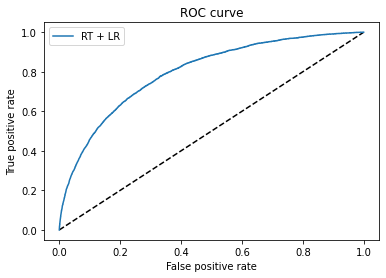

In [26]:
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(test_df.TARGET, test_df.TARGET_prob)

plt.figure(1) 
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#Feature importances

In [27]:
importances = model_gbm.feature_importances_
indices = np.argsort(importances)[::-1]

In [28]:
importance = variable_importance(importances, indices,x_calls)

Feature ranking:
1. The feature 'CREDIT_TERM' has a Mean Decrease in Gini of 4013.000000
2. The feature 'EXT_SOURCE_3' has a Mean Decrease in Gini of 3932.000000
3. The feature 'EXT_SOURCE_2' has a Mean Decrease in Gini of 3853.000000
4. The feature 'EXT_SOURCE_1' has a Mean Decrease in Gini of 2791.000000
5. The feature 'AMT_ANNUITY' has a Mean Decrease in Gini of 2386.000000
6. The feature 'DAYS_BIRTH' has a Mean Decrease in Gini of 2311.000000
7. The feature 'DAYS_ID_PUBLISH' has a Mean Decrease in Gini of 2131.000000
8. The feature 'client_installments_AMT_PAYMENT_min_sum' has a Mean Decrease in Gini of 2129.000000
9. The feature 'b_DAYS_CREDIT_max' has a Mean Decrease in Gini of 2123.000000
10. The feature 'YEARS_BIRTH' has a Mean Decrease in Gini of 2108.000000
11. The feature 'b_DAYS_ENDDATE_FACT_max' has a Mean Decrease in Gini of 2019.000000
12. The feature 'ANNUITY_TO_INCOME' has a Mean Decrease in Gini of 1997.000000
13. The feature 'AMT_GOODS_PRICE' has a Mean Decrease in G

In [29]:
importance

,Features,Gini
0,CREDIT_TERM,4013
1,EXT_SOURCE_3,3932
2,EXT_SOURCE_2,3853
3,EXT_SOURCE_1,2791
4,AMT_ANNUITY,2386
...,...,...
849,ORGANIZATION_TYPE_Mobile,0
850,b_CREDIT_TYPE_Loanforworkingcapitalreplenishme...,0
851,ORGANIZATION_TYPE_Industrytype1,0
852,preapp_CODE_REJECT_REASON_SYSTEM_sum,0


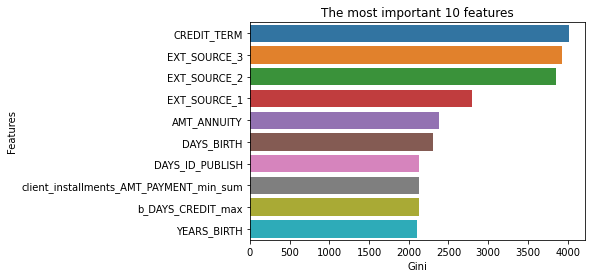

In [30]:
sns.barplot(importance.head(10)['Gini'], importance.head(10)['Features'])
plt.title("The most important 10 features")
plt.show()

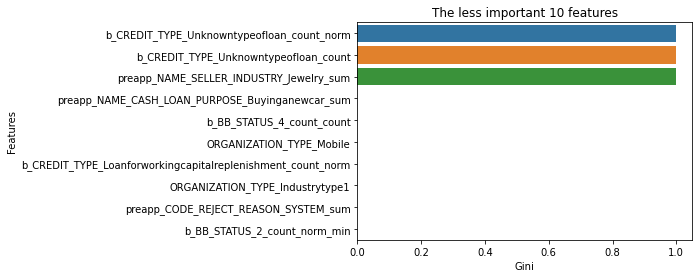

In [31]:
sns.barplot(importance.tail(10)['Gini'], importance.tail(10)['Features'])
plt.title("The less important 10 features")
plt.show()

In [32]:
zero_features = pd.DataFrame(importance[importance['Gini'] == 0.0]['Features'])
zero_features

,Features
847,preapp_NAME_CASH_LOAN_PURPOSE_Buyinganewcar_sum
848,b_BB_STATUS_4_count_count
849,ORGANIZATION_TYPE_Mobile
850,b_CREDIT_TYPE_Loanforworkingcapitalreplenishme...
851,ORGANIZATION_TYPE_Industrytype1
852,preapp_CODE_REJECT_REASON_SYSTEM_sum
853,b_BB_STATUS_2_count_norm_min


#Calculating the probability of application_test data

In [ ]:
# from sklearn.calibration import calibration_curve,CalibratedClassifierCV

# model_fix = CalibratedClassifierCV(model_gbm, cv='prefit', method='sigmoid')
# model_fix.fit(app_train[x_calls],app_train.TARGET)

In [ ]:
# gc.collect()
# data = pd.read_csv("/content/drive/MyDrive/Home Credit/home-credit-default-risk/dropped_test.csv")
# data.reset_index(inplace=True)
# app_test = data.rename(columns = {'index':'SK_ID_CURR'})

In [ ]:
# TARGET = model_fix.predict_proba(app_test[x_calls])[:,1]
# submission = pd.DataFrame({'SK_ID_CURR':app_test['SK_ID_CURR'],'TARGET':TARGET})

#Submission

In [ ]:
# submission.to_csv('/content/drive/MyDrive/Home Credit/home-credit-default-risk/submission.csv', index=False)
# submission.head()